# Preprocess Wine Reviews with [spaCy](https://spacy.io/)

Redo the NLP preprocessing using [spaCy](https://spacy.io/) since it seems to perform better. Refer to [NLP Selection](wine_reviews-nlp_selection.ipynb) for comparative performance analysis.

### Load Cleansed Wine Reviews

See [data preparation](wine_review-data_preparation.ipynb) for details on the prepared dataset.

Libraries

In [12]:
import pandas as pd
import numpy as np
from time import perf_counter

from IPython.display import Markdown, display
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

In [13]:
wine_df = pd.read_parquet('data/wine/wine_review.parquet.gzip')
wine_df.info()
wine_df[['title', 'winery', 'year', 'variety', 'description']].head()

<class 'pandas.core.frame.DataFrame'>
Index: 100538 entries, 0 to 129970
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   country         100538 non-null  object 
 1   description     100538 non-null  object 
 2   points          100538 non-null  int64  
 3   price           93522 non-null   float64
 4   taster_name     100538 non-null  object 
 5   title           100538 non-null  object 
 6   variety         100538 non-null  object 
 7   winery          100538 non-null  object 
 8   year            100538 non-null  int64  
 9   wine_style      100538 non-null  object 
 10  type            100538 non-null  object 
 11  quality         100538 non-null  object 
 12  classification  100538 non-null  object 
 13  location        100538 non-null  object 
 14  band            93522 non-null   object 
dtypes: float64(1), int64(2), object(12)
memory usage: 12.3+ MB


,title,winery,year,variety,description
0,Nicosia 2013 Vulkà Bianco (Etna),Nicosia,2013,White Blend,"Aromas include tropical fruit, broom, brimston..."
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),Quinta dos Avidagos,2011,Portuguese Red,"This is ripe and fruity, a wine that is smooth..."
2,Rainstorm 2013 Pinot Gris (Willamette Valley),Rainstorm,2013,Pinot Gris,"Tart and snappy, the flavors of lime flesh and..."
3,St. Julian 2013 Reserve Late Harvest Riesling ...,St. Julian,2013,Riesling,"Pineapple rind, lemon pith and orange blossom ..."
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Sweet Cheeks,2012,Pinot Noir,"Much like the regular bottling from 2012, this..."


### Preprocessing Pipeline

**Preprocessing Logic**

In [27]:
import spacy

nlp = spacy.load("en_core_web_lg")

def preprocess(doc):
  # drop punctuation, proper nouns, numbers and stop words
  keep = lambda token: (token[1] not in ['PUNCT','PROPN', 'NUM']) and (token[2] == 0)
  # run the preprocessing pipeline
  return (' '.join(map(lambda token: token[0], filter(keep, [(w.lemma_, w.pos_, w.is_stop) for w in nlp(doc)])))).strip()

**Verify the Preprocessing Logic**

In [28]:
# pick a review
description = wine_df.description.sample(random_state=28).values[0]

# display the original review
display(Markdown(description))

# display the preprocessed review
display(Markdown(preprocess(description)))

Savory on the nose with enough sweet blueberry to make it varietally enticing, this light purplish Syrah is well-balanced, pleasing and well-made, ready to drink now with a range of foods, its alcohol in proportion and acidity right on target. Wente blends in small percentages of Counoise, Petite Sirah, Mourvèdre and Tempranillo into this great-value Syrah. Delicious.

savory nose sweet blueberry varietally enticing light purplish balanced pleasing ready drink range food alcohol proportion acidity right target blend small percentage great value

### Preprocess the Reviews

**Single Thread Processing**

In [29]:
start = perf_counter()
tokens = (wine_df.title + '. ' + wine_df.description).progress_apply(preprocess)
display(Markdown((f'Preprocessing ${wine_df.shape[0]:,d}$ took ${(perf_counter()-start)/60:.0f}$ minutes to process.')))

100%|██████████| 100538/100538 [16:57<00:00, 98.84it/s] 


Preprocessing $100,538$ took $17$ minutes to process.

**Inspect the results**

In [30]:
tokens.info()
tokens

<class 'pandas.core.series.Series'>
Index: 100538 entries, 0 to 129970
Series name: None
Non-Null Count   Dtype 
--------------   ----- 
100538 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


0         aroma include tropical fruit broom brimstone d...
1         do ripe fruity wine smooth structure firm tann...
2         rainstorm tart snappy flavor lime flesh rind d...
3         pineapple rind lemon pith orange blossom start...
4         vintner like regular bottling come rough tanni...
                                ...                        
129966    note honeysuckle cantaloupe sweeten deliciousl...
129967    citation citation give decade bottle age prior...
129968    drain gravel soil give wine crisp dry characte...
129969    dry style crisp acidity weight solid powerful ...
129970    dit big rich dry power intense spiciness round...
Length: 100538, dtype: object

### Save the Preprocessing Results

In [31]:
pd.DataFrame(tokens, columns=['tokens'], index=wine_df.index).to_parquet('data/wine/wine_review-tokens.parquet.gzip',compression='gzip')

### Visualize the Preprocessing Results

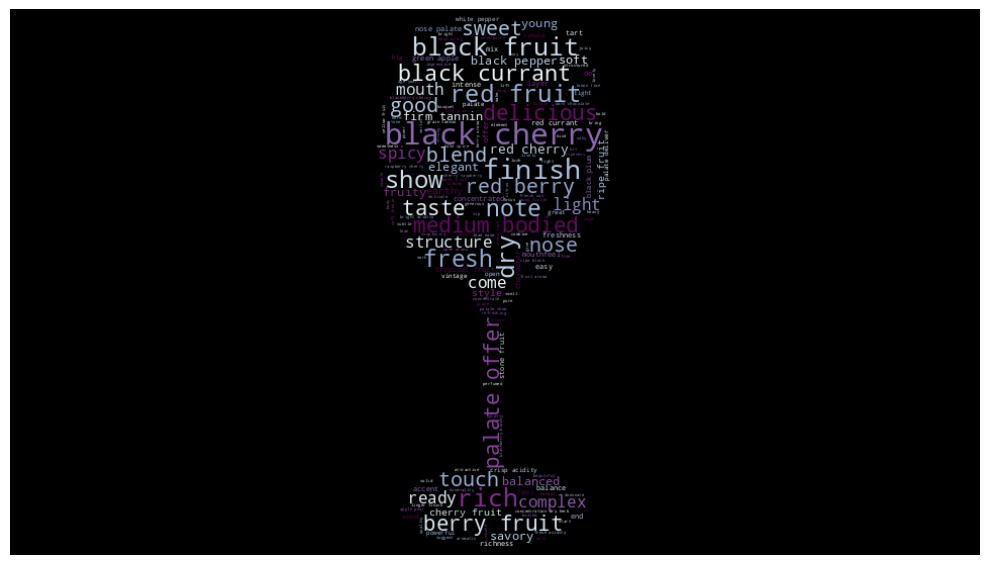

In [32]:
import wordcloud as wc
from PIL import Image

# helper Function for display frequency of words
def freq_words(words, title=None, show_v=False):
  '''
  Show frequency of words as an image
  '''

  stopwords = set(wc.STOPWORDS)
  stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

  # Generate frequency of words as an image
  mask = np.array(Image.open('images/Wineglass.png'))
  freq_words_img = wc.WordCloud(mask=mask, stopwords=stopwords, background_color='black', margin = 0, colormap='BuPu_r', width=2*960,height=2*540, max_words=2500).generate(words)

  # print the vector of words extracted from the description
  if show_v:
    print(freq_words_img.words_)

  # Display the image
  plt.figure(figsize=(10, 10))
  if title is not None:
    plt.title(title)
  plt.imshow(freq_words_img, interpolation="bilinear")
  plt.axis("off")
  plt.tight_layout()
  plt.show()

# show a word cloud of the features extracted from the description
freq_words(' '.join(tokens.to_list()))

# Next Step
- [NLP Feature Extraction](wine_review-feature_extraction.ipynb)